# Data Acquisition : World recipes #


## Preliminary Explanations ##

The idea behind this project is to collect data from recipes from different regions around the world, and later to exploit it. This jupyter notebook contains the code for the preliminary data acquisition step. Throughout the notebook, the use of functions are omnipresent to better reuse code and save time.

## Datasets ##

The main dataset that was used is not exactly one provided in the cluster. After careful analysis of the HTML webscraps in the recipe dataset, we found much more convenient to directly access the websites ourselves and scrap data on our own. The elected website was www.allrecipes.com. It is very structured, easy to navigate, and above all, all recipe pages are written the same way in HTML, a scraper's paradise. 

The site has little interesting details and perks that were exploited for our data collection. First of all, it is possible to add a 'print' statement to the URL to request a much cleaner HTML page, which facilitates scrapping immensely. Secondly, it is possible to specify in the URL the amount of servings the recipe is made for, and in which measuring system (metric, imperial) the ingredients' quantities have to be specified. Recipes are also given with a rating and the amount of people who pressed the 'made it' button which helps assess the recipe's popularity. By modifying the URL a bit, it is possible to request an HTML page containing the nutrition facts for the recipe (per serving), which does help quite a lot. Finally, the site is organized in a sort of tree structure, so it is easy to access all recipes in the same category (greek recipes for example).

We will comment the different scrapping and parsing functions as we go!

In [66]:
import re
import json, csv
import numpy as np
import requests, re
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

In [2]:
#The header describes who is visiting the website

headers = requests.utils.default_headers()
#'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/56.0.2924.87 Safari/537.36'

## Scrapping functions ##

url_gen: 

This function generates the correct url in function of the unit system, amount of servings, recipe reference and the type of data scrapping we may want to do. It is not the same url to get the nutrition facts, the recipe's popularity, or yet again the ingredients.

get_ingredients:

This function detects the ingredient list in the HTML (two column disposition) and appends them to a list for further treatment.

get_popularity:

This function detects the amounts of 'made it' and the rating of a recipe in the HTML page.

get_nutrition:

This function retrieves all the nutrition facts of the recipe, as well as it's official name.



In [2]:
def url_gen(ref,servings=1, metric = 'true', typeSearch = 'ingredients'):
    if typeSearch == 'none':
        tail = ''
    else :
        if typeSearch == 'nutrition':
            tail = 'fullrecipenutrition/'
        else:  
            tail = 'print/?recipeType=Recipe&servings={}&isMetric={}'.format(servings,metric)

    return ('https://www.allrecipes.com/recipe/' + ref+tail)

In [3]:
def get_ingredients(ref): 
    
    url = url_gen(ref)
    r=requests.get(url)
    
    ingredients = []
    soup = BeautifulSoup(r.text.encode('utf-8'),'lxml')    
    col1 = soup.find('h2').next_sibling.next_sibling
    col2 = col1.next_sibling.next_sibling

    for i in col1.findAll('li'):
        last=str(i.contents).rfind('r')
        first=str(i.contents).find('n')
        ingredients.append((str(i.contents)[(first+1):(last-1)].lstrip()))
    for i in col2.findAll('li'):
        last=str(i.contents).rfind('r')
        first=str(i.contents).find('n')
        ingredients.append((str(i.contents)[(first+1):(last-1)].lstrip()))
    return ingredients

In [4]:
def get_popularity(ref):    
    url = url_gen(ref,typeSearch = 'none')
    r=requests.get(url)
    soup = BeautifulSoup(r.text.encode('utf-8'),'lxml')    
    step1 =str(soup.findAll('div', class_="total-made-it"))
    step2 = str(soup.findAll('div', class_="rating-stars"))
    begin = '"made-it-count"></span><span>'
    end = '\xa0made it'
    step1 = step1[step1.find(begin)+len(begin):step1.find(end)]   
    begin = '<div class="rating-stars" data-ratingstars="'
    end= '" onclick'
    step2 = step2[step2.find(begin)+len(begin):step2.find(end)]  
    
    return step1,step2

In [5]:
def get_nutrition(ref):
#Returns a dictionnary with nutritional values

    url = url_gen(ref, typeSearch = 'nutrition')
    r=requests.get(url)
    soup = BeautifulSoup(r.text.encode('utf-8'),'lxml') 
    info = soup.findAll('div', class_='nutrition-row')
    general = {}
    general['Title']  = str(soup.find('h2').contents[0])
    general['Reference'] = ref
    nutrition = {}
    getCal = str(soup.find('div', class_="nutrition-top light-underline"))
    key = 'Calories:</span> '
    nutrition['Calories'] = (getCal[getCal.find(key) + len(key):getCal.rfind('<br/>')])
    
    for i in info:
        a=i.find(class_='nutrient-name')
        b = re.findall('>(.*?):', str(a))[0]
        c = re.findall('value">(.*?)<', str(a))[0]
       # print(str(b) + ' : ' + str(c))
        nutrition[b] = c
    return general, nutrition

## Forming a class ##

To help with program structure, a Recipe class is made. In its constructor, the previously explained methods are called, so a recipe can be fully retrieved solely by creating a new Recipe object. Aditional useful methods are added to better display the object, to export it as a dictionnary, to a dataframe...

In [6]:
class Recipe:
    def __init__(self, name):
        self.name = name
        self.ingredients = get_ingredients(name)
        self.general, self.nutrition = get_nutrition(name)
        s1,s2 = get_popularity(name)
        self.general['Popularity'] = s1
        self.general['Rating']=s2
    def display(self):
        print('\n ----------------- \n')
        print(self.general)
        print('\n')
        print(self.ingredients)
        print('\n')
        print(self.nutrition)
    def toDict(self):
        dictio = {}
        dictio['General'] = self.general
        dictio['Nutrition'] = self.nutrition
        dictio['Ingredients'] = self.ingredients
        return dictio

In [7]:
def toDf(a, Region = 'Unknown'):
    dic = a.general
    tmp = {}
    tmp['Region'] = Region
    dic.update(tmp)
    dic.update(a.nutrition)
    RecipeDf = pd.DataFrame.from_dict(dic,orient = 'index')
    RecipeDf.columns = [str(a.general['Title'])]
    return RecipeDf

## Time for an example ##

Instanciating an object for this particular tikka masala recipe, then exporting it as a dictionnary yields this result.The object's attributes are of course accessible individually.


In [11]:
#ref = '246179/black-chana-with-potato/'
ref = '45736/chicken-tikka-masala/'
Recipe(ref).toDict()

{'General': {'Title': 'Chicken Tikka Masala',
  'Reference': '45736/chicken-tikka-masala/',
  'Popularity': '3k',
  'Rating': '4.38908433914185'},
 'Nutrition': {'Calories': '404',
  'Total Fat': '28.9g',
  'Saturated Fat': '17.0g',
  'Cholesterol': '143mg',
  'Sodium': '1592mg',
  'Potassium': '660mg',
  'Total Carbohydrates': '13.3g',
  'Dietary Fiber': '2.5g',
  'Protein': '24.6g',
  'Sugars': '7g',
  'Vitamin A': '2432IU',
  'Vitamin C': '11mg',
  'Calcium': '206mg',
  'Iron': '3mg',
  'Thiamin': '0mg',
  'Niacin': '13mg',
  'Vitamin B6': '1mg',
  'Magnesium': '57mg',
  'Folate': '24mcg'},
 'Ingredients': ['60 ml yogurt',
  '4 ml lemon juice',
  '1 g fresh ground cumin',
  '0.6 g ground cinnamon',
  '0.9 g cayenne pepper',
  '1 g freshly ground black pepper',
  '1 g minced fresh ginger',
  '2 g salt, or to taste',
  '3/4 boneless skinless chicken breasts, cut into bite-size pieces',
  '1 long skewers',
  '4 g butter',
  '1/4 clove garlic, minced',
  '1/4 jalapeno pepper, finely cho

## Large Scale Generalization ## 

In data analysis, what we really need is data. The next few functions, help generalizing the data scrapping to a larger scale in order to later be processed.

get_recipes:

This function is given the URL of the theme's page (greek recipes for example). It then searches the webpage for recipe links that are of course linked to the theme. By default, this function returns the first 20 recipes the site shows. The shown recipes present the advantage of being diverse and pretty representative of the country's culinar culture. A retrieval of more recipes, to later only keep the 20 most popular was considered, but the recipe's popularity mainly depend on the american visitors of the website and their taste buds may be too biased for this technique to be representative.

getThemeRecipes:

The magic function! For each of the links generated by get_recipes(), this function generates a recipe object. The objects are also processed to potentially return three things. First, a list of all recipe objects. This is the least useful of the three. This function also returns a Pandas dataframe containing all of the information of all the recipe objects, except for the ingredients which have an unknown size and vary between recipes. Finally, it returns a dictionary containing all the information of all the recipe objects, hierarchally arranged so as to be able to export it easily as a JSON file.

getInfo:

This function calls getThemeRecipes, then exports the information. It exports and saves the dataframe as a CSV file, and the dictionnary as a JSON. This allows the scrapped data to be stored and accessible much more rapidly, without depending on website changes.

In [8]:
def get_recipes(themeUrl, number = 20):
    
    r=requests.get(themeUrl) #add page 1,2,etc
    
    baseUrl = 'https://www.allrecipes.com/recipe/'
    soup = BeautifulSoup(r.text.encode('utf-8'),'lxml') 
    results = soup.findAll('h3', class_='fixed-recipe-card__h3')
    
    theme = []
    iteration = 0
    for i in results :
        
        if iteration  == number:
            break
            
        iteration = iteration + 1
        
        link = str(i.find('a').get('href'))
        first=link.find(baseUrl)
        theme.append(link[(first+len(baseUrl)):])
        
    return theme

In [9]:
def getThemeRecipes(themeName, number = 20, dec =1):
    tail = ''
    for i in range(1,len(themeName)-1):
        tail = tail + themeName[i]+'/'
    themeUrl = 'https://www.allrecipes.com/recipes/'+themeName[0]+'/world-cuisine/'+tail
    themeLinks = get_recipes(themeUrl, number = number)
    themeRecipes = []
    themeDico = {}

    from tqdm import tqdm_notebook as tqdm

    for i in tqdm(range(len(themeLinks))):
        recipe = themeLinks[i]
        
        
    #for recipe in themeLinks:
        try:
            current = Recipe(recipe)
            if i == 0:
                joined = toDf(current, themeName[len(themeName)-dec] );
            else:
                joined = pd.merge(joined,toDf(current,themeName[len(themeName)-dec]), left_index=True, right_index=True, how = 'outer')
                    
            #themeRecipes.append(current)
            themeDico[current.general['Reference']] = current.toDict()
            
        except AttributeError:
            print('Error')
            continue
    return themeDico, joined

In [10]:
def getInfo(themeName, dec=1):
    themeDico, themeDf = getThemeRecipes(themeName,dec = dec)
    
    data_path = 'data/'
    themeDf.transpose().dropna().to_csv(data_path + themeName[len(themeName) - dec]+'.csv')
   
    with open(data_path + themeName[len(themeName) - dec]+'.json', 'w') as f:
        json.dump(themeDico, f)
    

## Let's run everything ##

Each region is associated with a number, and multiple categories and sub-categories. Since the site has a timeout after a certain amount of 'suspicious' connections, it is more convenient to scrape each category one by one (takes about a minute, progress bar showed with tqdm). 

In [15]:
themeIndian = ['17136','asian','indian','main-dishes']
themeJapanese = ['17491','asian','japanese','main-dishes']
themeMexican = ['17504','latin-american','mexican','main-dishes']
themeItalian = ['16767','european','italian','main-dishes']
themeLebanese = ['1824','middle-eastern','lebanese']
themeFrench = ['721','european','french']
themeNorthAfrican = ['17582','african','north-african']

getInfo(themeNorthAfrican)
getInfo(themeItalian, dec = 2)
getInfo(themeIndian, dec = 2)
getInfo(themeJapanese, dec = 2)
getInfo(themeMexican, dec = 2)
getInfo(themeLebanese)
getInfo(themeFrench)

themeChinese = ['17135','asian','chinese','main-dishes']
themeThai = ['702','asian','thai']
themeSA = ['730','latin-american','south-american']
themeGreek = ['17152','european','greek','main-dishes']

getInfo(themeChinese, dec = 2)
getInfo(themeSA)
getInfo(themeThai)
getInfo(themeGreek, dec = 2)

themeScand = ['725','european','scandinavian']
themeUK = ['704','european','uk-and-ireland']
themeEastEurope = ['712','european','eastern-european']
getInfo(themeScand)
getInfo(themeUK)
getInfo(themeEastEurope)

themeGerman = ['722','european','german']
themeSpanish = ['726','european','spanish']
getInfo(themeGerman)
getInfo(themeSpanish)

themeEastAfrican =  ['17845','african','east-african']
getInfo(themeEastAfrican)

Error



Error
Error
Error



In [48]:
themeCanadian =  ['733','canadian']
getInfo(themeCanadian)
themeAustralian = ['228','australian-and-new-zealander']
getInfo(themeAustralian)

In [41]:
Mexican = pd.read_csv('data/mexican.csv',index_col = 0).dropna()
Indian = pd.read_csv('data/indian.csv',index_col = 0)
Italian = pd.read_csv('data/italian.csv',index_col = 0)
Lebanese = pd.read_csv('data/lebanese.csv',index_col = 0)
French = pd.read_csv('data/french.csv',index_col = 0)
Japanese = pd.read_csv('data/japanese.csv',index_col = 0)

NorthAfrican = pd.read_csv('data/north-african.csv',index_col = 0)
Chinese = pd.read_csv('data/chinese.csv',index_col = 0)
SA = pd.read_csv('data/south-american.csv',index_col = 0)
Thai = pd.read_csv('data/thai.csv',index_col = 0)
Greek = pd.read_csv('data/greek.csv',index_col = 0)


Scand = pd.read_csv('data/scandinavian.csv',index_col = 0)
UK = pd.read_csv('data/uk-and-ireland.csv',index_col = 0)
EastEurope = pd.read_csv('data/eastern-european.csv',index_col = 0)
German = pd.read_csv('data/german.csv',index_col = 0)
Spanish = pd.read_csv('data/spanish.csv',index_col = 0)
EastAfrican = pd.read_csv('data/east-african.csv',index_col = 0)

Canadian = pd.read_csv('data/canadian.csv',index_col = 0)
Australian = pd.read_csv('data/australian-and-new-zealander.csv',index_col = 0)

Full = Mexican.append(Indian,sort=True).append(Italian,sort=True).append(Lebanese,sort=True).append(French,sort=True).append(Japanese,sort=True)
Full = Full.append(NorthAfrican,sort=True).append(Chinese,sort=True).append(SA,sort=True).append(Thai,sort=True).append(Greek,sort=True)
Full = Full.append(Scand,sort=True).append(UK,sort=True).append(EastEurope,sort=True).append(German,sort=True).append(Spanish,sort=True)
Full = Full.append(EastAfrican,sort=True)
Full = Full.append(Canadian,sort=True).append(Australian,sort=True)

Full.dropna().to_csv('data/fullData.csv')

len(Full)

367

## Data Parsing ##

Now that we have data, let's clean it! We associate each nutrient with it's unit, no error in running it means there are no irregularities, and we get a decimal number with each quantity.

In [42]:
dicUnits = {}
dicUnits['Iron']='mg'
dicUnits['Niacin']='mg'
dicUnits['Magnesium']='mg'
dicUnits['Calcium']='mg'
dicUnits['Cholesterol']='mg'
dicUnits['Sodium']='mg'
dicUnits['Potassium']='mg'
dicUnits['Vitamin C']='mg'
dicUnits['Thiamin']='mg'
dicUnits['Vitamin B6']='mg'


dicUnits['Total Carbohydrates']='g'
dicUnits['Protein']='g'
dicUnits['Dietary Fiber']='g'
dicUnits['Total Fat']='g'
dicUnits['Saturated Fat']='g'
dicUnits['Sugars']='g'

dicUnits['Folate']='mcg'

dicUnits['Popularity']='k'

def replaceUnits(x,elem):
    if elem == 'Popularity':
        return int(x.replace(dicUnits[str(elem)],'000'))
    else:
        a=0
        try:
            return float(x.replace(dicUnits[str(elem)],''))
        except:
             print('weird format'+x)
                                               
        else:
            return 1   #the 3 cases

                         
    

def treatUnits(Original):
    Treated = Original.copy()
    for elem in dicUnits:
        if elem == 'Popularity':
            Treated[str(elem)]=Original[str(elem)].apply(lambda x : float(str(x).replace(dicUnits[str(elem)],'000')))
        else:
            Treated[str(elem)]=Original[str(elem)].apply(lambda x : replaceUnits(x,elem))
    return Treated

In [43]:
#Full = pd.read_csv('data/fullData.csv',index_col = 0)
Full = treatUnits(Full)
Full.to_csv('data/fullTreated.csv')
Full.head()

weird format&lt; 1mg


,Calcium,Calories,Cholesterol,Dietary Fiber,Folate,Iron,Magnesium,Niacin,Popularity,Potassium,...,Saturated Fat,Sodium,Sugars,Thiamin,Title,Total Carbohydrates,Total Fat,Vitamin A,Vitamin B6,Vitamin C
Fresh Shrimp Boil,193.0,420,376.0,4.0,47.0,7.0,115.0,15.0,27.0,709.0,...,8.0,7527.0,3.0,0.0,Fresh Shrimp Boil,19.9,15.2,4876IU,1.0,22.0
Low-Carb Jicama Tostadas,18.0,57,0.0,7.4,18.0,1.0,18.0,0.0,3.0,225.0,...,0.0,6.0,3.0,0.0,Low-Carb Jicama Tostadas,13.2,0.1,32IU,0.0,30.0
Best Fish Tacos,80.0,322,35.0,3.8,88.0,3.0,48.0,6.0,3.0,591.0,...,3.0,833.0,2.0,0.0,Best Fish Tacos,34.6,9.0,1043IU,0.0,18.0
Crispy Pork Carnitas,35.0,317,89.0,0.4,5.0,2.0,23.0,10.0,268.0,371.0,...,6.0,1036.0,0.0,1.0,Crispy Pork Carnitas,2.1,22.6,17IU,0.0,2.0
Jeannie's Vegetarian Enchiladas,376.0,626,59.0,9.6,193.0,6.0,77.0,8.0,1.0,818.0,...,15.0,1138.0,5.0,1.0,Jeannie's Vegetarian Enchiladas,67.2,31.2,2569IU,0.0,49.0


In [44]:
#Example of what we can get with this dataset

treatUnits(French)['Saturated Fat'].describe()

count    18.000000
mean     12.111111
std      10.498677
min       0.000000
25%       5.000000
50%       8.500000
75%      19.750000
max      33.000000
Name: Saturated Fat, dtype: float64

## Working with ingredients ##

We want to be able to work and exploit the ingredient list. To that end, we have to be able to separate each ingredients from its quantity, and this is the goal of the function ingr2dic.For each item, it retrieves the name, unit and quantity. It also takes cares of several formatting styles such as '1/2 can (16 ounces)' which will be  converted to grams, the '1/8 lettuce' which will be converted to '0.125', 'lettuce', 'no unit'.

We are however interesting in getting the quantity in grams of our fruits and vegetables for our future nutriscore calculations. We thus scrapped two other webpages with a list of fruits and vegetables, converted the veggies in plural form to their singular counterparts, and exported the list as a csv.

With that list, we are able to run the list with the ingredients of the recipes (loaded from the json as a dictionary), and when it matches, retrieve the weight of the given fruit by looking in the Veg2Quant lookup table and multiplying by the quantity. The sum of vegetable-based ingredients is computed in the getIngGram() function.

In [45]:
def ingr2dic(ingredients):
    ingredientDic = {}
    itera = 0
    for i in ingredients:
        itera = itera+1
        parsed = re.match('(\d+([\.,\/]\d+)?)\s+((g|ml|pinch|clove)\s)?', i)   #needs improvement
        if (parsed) != None:
            dic = {}

            if i.find(',')>0:
                name = i[len(parsed[0]):i.find(',')]
            else:
                name = i[len(parsed[0]):]
            dic['name']=name
            dic['unit']     = parsed[4]
            
            #Converting the '1/8 lettuce' to decimal form '0.125 lettuce'
            if re.match('\d\/\d+',parsed[1]):
                p = re.match('(\d)\/(\d)',parsed[1])
                dic['quantity']     = float(p[1])/int(p[2])
            else:    
                dic['quantity'] = parsed[1]
                
            #conversion from ounces
            parsed = re.match('\((\d+(\.\d+?)?)\s+(ounce)\)', name)
            if parsed != None:
                name = name[len(parsed[0]):]
                dic['name']=name
                dic['quantity'] = int(28.3*float(parsed[1]))
                dic['unit']     = 'g'
            
            ingredientDic[str(itera)]=dic
    return ingredientDic

In [46]:
#Getting a list of vegetables and fruits to compare through web scraping

url = 'http://vegetablesfruitsgrains.com/list-of-vegetables/'
r=requests.get(url)
soup = BeautifulSoup(r.text.encode('utf-8'),'lxml')    
a = soup.findAll('li')
url = 'http://vegetablesfruitsgrains.com/list-of-fruits/'
r=requests.get(url)
soup = BeautifulSoup(r.text.encode('utf-8'),'lxml')    
b = soup.findAll('li')
vegies = []
for i in a:
    if '>' not in str(i.contents[0]):
        c=str(i.contents[0]).split('/')
        for j in c:
            d=j.split('-')[0]
            vegies.append(d)
for i in b:
    if '>' not in str(i.contents[0]):
        c=str(i.contents[0]).split('/')
        for j in c:
            d=j.split('-')[0]
            vegies.append(d)
            
with open('data/vegies.csv', 'w') as myfile:
    wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
    wr.writerow(vegies)


In [47]:
#reading vegies.csv
with open('data/vegies.csv', 'r') as myfile:
    r = csv.reader(myfile)
    veg = list(r)[0]

#Adding non plural forms
for i in veg:
    if i[-1]=='s':
        veg.append(i[:-1])

In [48]:
#reading vegies.csv
with open('data/vegies.csv', 'r') as myfile:
    r = csv.reader(myfile)
    veg = list(r)[0]

#Adding non plural forms
for i in veg:
    if i[-1]=='s':
        veg.append(i[:-1])
        
#Vegetable Grammage dictionnary: for milestone 2

#Would be better to have everything in the Veg list and have it as a JSON!

Veg2QuantDic={}
Veg2QuantDic['tomato']=100
Veg2QuantDic['lime']= 50
Veg2QuantDic['lemon']= 100
Veg2QuantDic['lettuce']= 700
Veg2QuantDic['orange']= 130
Veg2QuantDic['oranges']= 130
Veg2QuantDic['onion']= 100
Veg2QuantDic['pepper']= 160
Veg2QuantDic['grapefruit']= 400
Veg2QuantDic['avocado']= 220
Veg2QuantDic['banana']= 120
Veg2QuantDic['potato']= 140
Veg2QuantDic['peach']= 120
Veg2QuantDic['carrot']= 130
Veg2QuantDic['peppers']= 160
Veg2QuantDic['bell pepper']= 160
Veg2QuantDic['celery']= 120
Veg2QuantDic['cabbage']= 300
Veg2QuantDic['leaf']= 200
Veg2QuantDic['shallot']= 100
Veg2QuantDic['shallots']= 100
Veg2QuantDic['eggplant']= 225
Veg2QuantDic['cucumber']= 250
Veg2QuantDic['parsley']= 50
Veg2QuantDic['zucchini']= 200
Veg2QuantDic['ginger']= 100
Veg2QuantDic['garlic']= 10
Veg2QuantDic['peas']= 100
Veg2QuantDic['bok choy']= 100
Veg2QuantDic['squash']= 300
Veg2QuantDic['olive']= 50
Veg2QuantDic['kale']= 200
Veg2QuantDic['broccoli']= 400
Veg2QuantDic['mango']= 300
Veg2QuantDic['lemongrass']= 100
Veg2QuantDic['mushrooms']= 100
Veg2QuantDic['rutabaga']= 160
Veg2QuantDic['spinach']= 200
Veg2QuantDic['leeks']= 200
Veg2QuantDic['leek']= 200
Veg2QuantDic['corn']= 100
Veg2QuantDic['apple']= 160
Veg2QuantDic['pumpkin']= 3000
Veg2QuantDic['cauliflower']= 500
Veg2QuantDic['beet']= 160
Veg2QuantDic['green']= 100
Veg2QuantDic['greens']= 100

with open('data/veggies.json', 'w') as f:
        json.dump(Veg2QuantDic, f)

In [49]:
def getVegGrams(a, ref):
    #Iterate through ingredient list, parse quantities, and detect veggetables
    #If a vegetable correspond to a list value, add it to the weight
    
    
    recipe = ingr2dic(a[ref]['Ingredients'])

    quantity = 0
    for ingredient in recipe:
        name = recipe[ingredient]['name'].lower()
       # print(name)
        for word in veg:
            if word.lower() in name:
        #if any(word.lower() in name for word in veg):
                tmpQuantity = 0
                if recipe[ingredient]['unit'] == 'g':
                    tmpQuantity = float(recipe[ingredient]['quantity'])
                else:
                    if recipe[ingredient]['unit'] == None:
                        if word.lower() in Veg2QuantDic.keys():
                            tmpQuantity = float(Veg2QuantDic[word.lower()])*recipe[ingredient]['quantity']
                        else:
                            print("Add to Dic:" + word.lower())
                            tmpQuantity = 60 #estimated guess
                quantity = tmpQuantity + quantity          
                print("Detected: \t\t" + str(word.lower()) + ' : ' + str(tmpQuantity) + ' g')
                break  #avoid multiple detection
    return int(quantity)

In [50]:
with open('data/mexican'+'.json', 'rb') as f:
        a=json.load(f)
ingr2dic(a['258250/jeannies-vegetarian-enchiladas/']['Ingredients'])
#dico compare

{'1': {'name': 'vegetable oil', 'unit': 'ml', 'quantity': '4'},
 '2': {'name': 'bunch green onions', 'unit': None, 'quantity': 0.25},
 '3': {'name': 'large red bell pepper', 'unit': None, 'quantity': 0.125},
 '4': {'name': 'garlic', 'unit': 'clove', 'quantity': 0.375},
 '5': {'name': 'large tomato', 'unit': None, 'quantity': 0.125},
 '6': {'name': 'sliced black olives', 'unit': 'g', 'quantity': '9'},
 '7': {'name': 'jalapeno peppers', 'unit': None, 'quantity': 0.25},
 '8': {'name': 'drained canned black beans', 'unit': 'g', 'quantity': '60'},
 '9': {'name': 'cooked white rice', 'unit': 'g', 'quantity': '30'},
 '10': {'name': ' package cream cheese', 'unit': 'g', 'quantity': 226},
 '11': {'name': 'shredded Cheddar cheese', 'unit': 'g', 'quantity': '20'},
 '12': {'name': 'chopped fresh cilantro', 'unit': 'g', 'quantity': '3'},
 '13': {'name': 'lime', 'unit': None, 'quantity': 0.125},
 '14': {'name': 'dash hot sauce (such as Tabasco(R))',
  'unit': None,
  'quantity': 0.125},
 '15': {'nam

In [51]:
with open('data/mexican'+'.json', 'rb') as f:
        a=json.load(f)
                    
ref = '258250/jeannies-vegetarian-enchiladas/'

print('\n Grams of vegetables detected: ' + str(getVegGrams(a,ref)) + ' g .')

Detected: 		onion : 25.0 g
Detected: 		bell pepper : 20.0 g
Detected: 		garlic : 0 g
Detected: 		tomato : 12.5 g
Detected: 		olive : 9.0 g
Detected: 		peppers : 40.0 g
Detected: 		beans : 60.0 g
Detected: 		lime : 6.25 g

 Grams of vegetables detected: 172 g .


# Nutriscore calculations #

Let's calculate the nutriscore for every recipe. Documentation for the formulas are available at the following link:


This will be done in three steps:

1) Calculating the weight of every vegetable based products in the recipes

2) Calculating the total weight of the recipe, in order to normalize every unit to a 100g serving

3) Applying formulas


In [52]:
Full = pd.read_csv('data/fullTreated.csv',index_col = 0)
Full.head(8)

,Calcium,Calories,Cholesterol,Dietary Fiber,Folate,Iron,Magnesium,Niacin,Popularity,Potassium,...,Saturated Fat,Sodium,Sugars,Thiamin,Title,Total Carbohydrates,Total Fat,Vitamin A,Vitamin B6,Vitamin C
Fresh Shrimp Boil,193.0,420,376.0,4.0,47.0,7.0,115.0,15.0,27.0,709.0,...,8.0,7527.0,3.0,0.0,Fresh Shrimp Boil,19.9,15.2,4876IU,1.0,22.0
Low-Carb Jicama Tostadas,18.0,57,0.0,7.4,18.0,1.0,18.0,0.0,3.0,225.0,...,0.0,6.0,3.0,0.0,Low-Carb Jicama Tostadas,13.2,0.1,32IU,0.0,30.0
Best Fish Tacos,80.0,322,35.0,3.8,88.0,3.0,48.0,6.0,3.0,591.0,...,3.0,833.0,2.0,0.0,Best Fish Tacos,34.6,9.0,1043IU,0.0,18.0
Crispy Pork Carnitas,35.0,317,89.0,0.4,5.0,2.0,23.0,10.0,268.0,371.0,...,6.0,1036.0,0.0,1.0,Crispy Pork Carnitas,2.1,22.6,17IU,0.0,2.0
Jeannie's Vegetarian Enchiladas,376.0,626,59.0,9.6,193.0,6.0,77.0,8.0,1.0,818.0,...,15.0,1138.0,5.0,1.0,Jeannie's Vegetarian Enchiladas,67.2,31.2,2569IU,0.0,49.0
Mexican Corn Bread Casserole,168.0,304,101.0,1.9,58.0,2.0,28.0,6.0,21.0,372.0,...,8.0,708.0,4.0,0.0,Mexican Corn Bread Casserole,21.5,16.3,840IU,0.0,12.0
Cochinita Pibil (Mexican Pulled Pork in Annatto Sauce),56.0,422,122.0,0.9,28.0,2.0,49.0,16.0,3.0,811.0,...,9.0,1334.0,5.0,2.0,Cochinita Pibil (Mexican Pulled Pork in Annatt...,8.3,25.6,158IU,1.0,31.0
Authentic Mexican Chili Rellenos,312.0,263,102.0,1.1,50.0,2.0,26.0,3.0,519.0,217.0,...,8.0,357.0,3.0,0.0,Authentic Mexican Chili Rellenos,17.3,16.0,594IU,0.0,65.0


In [53]:
Full[Full['Region']=='mexican'].head()

,Calcium,Calories,Cholesterol,Dietary Fiber,Folate,Iron,Magnesium,Niacin,Popularity,Potassium,...,Saturated Fat,Sodium,Sugars,Thiamin,Title,Total Carbohydrates,Total Fat,Vitamin A,Vitamin B6,Vitamin C
Fresh Shrimp Boil,193.0,420,376.0,4.0,47.0,7.0,115.0,15.0,27.0,709.0,...,8.0,7527.0,3.0,0.0,Fresh Shrimp Boil,19.9,15.2,4876IU,1.0,22.0
Low-Carb Jicama Tostadas,18.0,57,0.0,7.4,18.0,1.0,18.0,0.0,3.0,225.0,...,0.0,6.0,3.0,0.0,Low-Carb Jicama Tostadas,13.2,0.1,32IU,0.0,30.0
Best Fish Tacos,80.0,322,35.0,3.8,88.0,3.0,48.0,6.0,3.0,591.0,...,3.0,833.0,2.0,0.0,Best Fish Tacos,34.6,9.0,1043IU,0.0,18.0
Crispy Pork Carnitas,35.0,317,89.0,0.4,5.0,2.0,23.0,10.0,268.0,371.0,...,6.0,1036.0,0.0,1.0,Crispy Pork Carnitas,2.1,22.6,17IU,0.0,2.0
Jeannie's Vegetarian Enchiladas,376.0,626,59.0,9.6,193.0,6.0,77.0,8.0,1.0,818.0,...,15.0,1138.0,5.0,1.0,Jeannie's Vegetarian Enchiladas,67.2,31.2,2569IU,0.0,49.0


In [54]:
def ingr2dic(ingredients):
    ingredientDic = {}
    itera = 0
    for i in ingredients:
        itera = itera+1
        parsed = re.match('(\d+([\.,\/]\d+)?)\s+((g|ml|pinch|clove)\s)?', i)   #needs improvement
        if (parsed) != None:
            dic = {}

            if i.find(',')>0:
                name = i[len(parsed[0]):i.find(',')]
            else:
                name = i[len(parsed[0]):]
            dic['name']=name
            dic['unit']     = parsed[4]
            
            #Converting the '1/8 lettuce' to decimal form '0.125 lettuce'
            if re.match('\d\/\d+',parsed[1]):
                p = re.match('(\d)\/(\d)',parsed[1])
                dic['quantity']     = float(p[1])/int(p[2])
            else:    
                dic['quantity'] = float(parsed[1])
                
            #conversion from ounces
            parsed = re.match('\((\d+(\.\d+?)?)\s+(ounce)\)', name)
            if parsed != None:
                name = name[len(parsed[0]):]
                #print(dic['quantity'])
                dic['name']=name
                #print(int(28.3*float(parsed[1])*dic['quantity']))
                dic['quantity'] = int(28.3*float(parsed[1])*dic['quantity'])
                dic['unit']     = 'g'
               
            
            ingredientDic[str(itera)]=dic
    return ingredientDic

In [55]:
def getVegGrams(a, ref):
    #Iterate through ingredient list, parse quantities, and detect veggetables
    #If a vegetable correspond to a list value, add it to the weight
    
    
    recipe = ingr2dic(a[ref]['Ingredients'])

    quantity = 0
    for ingredient in recipe:
        name = recipe[ingredient]['name'].lower()
       # print(name)
        for word in veg:
            if word.lower() in name:
        #if any(word.lower() in name for word in veg):
                tmpQuantity = 0
                if recipe[ingredient]['unit'] == 'g':
                    tmpQuantity = float(recipe[ingredient]['quantity'])
                else:
                    if recipe[ingredient]['unit'] == None:
                        if word.lower() in VegDic.keys():
                            tmpQuantity = float(VegDic[word.lower()])*float(recipe[ingredient]['quantity'])
                            
                        else:
                            print("Add to Dic:" + word.lower())
                            print(recipe[ingredient])
                            tmpQuantity = 60 #estimated guess
                quantity = tmpQuantity + quantity          
                #print("Detected: \t\t" + str(word.lower()) + ' : ' + str(tmpQuantity) + ' g')
                break  #avoid multiple detection
    return int(quantity)

In [56]:
with open('data/veggies.json', 'rb') as f:
        VegDic=json.load(f)
        
#reading vegies.csv
with open('data/vegies.csv', 'r') as myfile:
    r = csv.reader(myfile)
    veg = list(r)[0]

#Adding non plural forms
for i in veg:
    if i[-1]=='s':
        veg.append(i[:-1])

In [58]:
#Calculating the veggetable weights for all recipes in the dataset
Full = pd.read_csv('data/fullTreated.csv',index_col = 0)

listVeg = []
listNutri = []
listLetter = []

for index, row in Full.iterrows(): 
    jsonPath='data/'+row['Region']+'.json'
    #print(row['Reference'])
    with open(jsonPath, 'rb') as f:
        a=json.load(f)
        #print(ingr2dic(a[row['Reference']]['Ingredients']))
        #print('\n Grams of vegetables detected: ' + str(getVegGrams(a,row['Reference'])) + ' g .')
        #Full['VeggieWeight'] = getVegGrams(a,row['Reference'])
        VeggieWeight = float(getVegGrams(a,row['Reference']))
        listVeg.append(VeggieWeight)
        
        #quantities are normalized to a 100g basis (we consider meals weight around 400grams)
        servingRatio = 0.25
        NegPoints = int(row.Calories/(335./4.184))+int(row.Sugars/(4.5))+int(row['Saturated Fat']/(1))+int(row.Sodium/90)
        NegPoints = int(NegPoints*servingRatio)
        
        if VeggieWeight <= 120:
            fruitPoints = 0
        if VeggieWeight > 120 and VeggieWeight <= 180:
            fruitPoints = 1
        if VeggieWeight > 180 and VeggieWeight <= 240:
            fruitPoints = 2
        if VeggieWeight > 240:
            fruitPoints = 5
     
        PosPoints = fruitPoints + int(servingRatio*row.Protein/(1.6)) + int(servingRatio*row['Dietary Fiber']/(0.9))
        score = NegPoints - PosPoints
        listNutri.append(score)
    
        if score <= -1:
            letter = 'A'
        if score > -1 and score <= 2:
            letter = 'B'
        if score > 2 and score <= 10:
            letter = 'C'
        if score > 10 and score <= 19:
            letter = 'D'
        if score > 19:
            letter = 'E'
        listLetter.append(letter)
            
            
Full['VeggieWeight'] = listVeg
Full['NutriScore'] = listNutri
Full['NutriLetter'] = listLetter

In [59]:
Full.sort_values(by=['NutriScore'])['NutriScore']

Pollo Adobado                                              -8
Yam Taeng (Spicy Cucumber Salad)                           -8
Make-Ahead Vegetarian Moroccan Stew                        -8
Moo Goo Gai Pan                                            -8
Greek Pasta with Tomatoes and White Beans                  -8
Moroccan Lentil Soup                                       -7
Silpancho from Cochabamba, Bolivia                         -7
Brazilian Chicken with Coconut Milk                        -6
Avocado and Tuna Tapas                                     -6
Kik Wat (Ethiopian Red Lentil Stew)                        -6
Lengenberg's Boiled Potatoes                               -6
Cholay (Curried Chickpeas)                                 -6
Bhuna Gosht                                                -6
Bissara                                                    -6
Kay's Spaghetti and Lasagna Sauce                          -6
Key Sir Alicha (Ethiopian Beets and Potatoes)              -6
Ethiopia

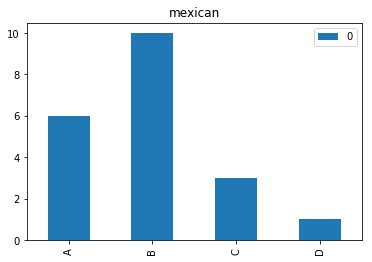

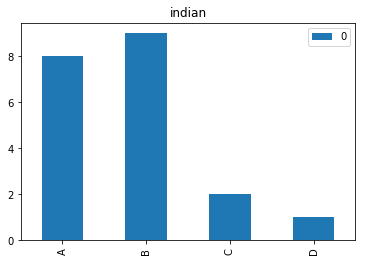

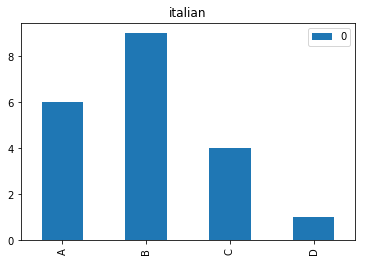

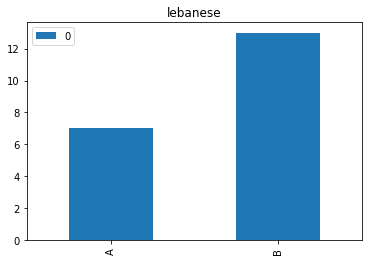

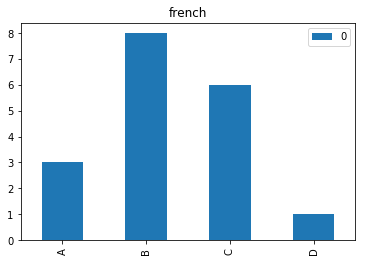

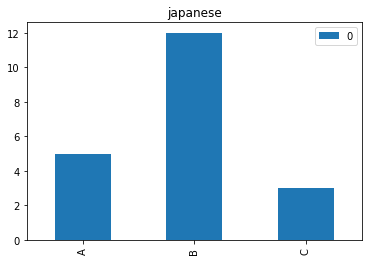

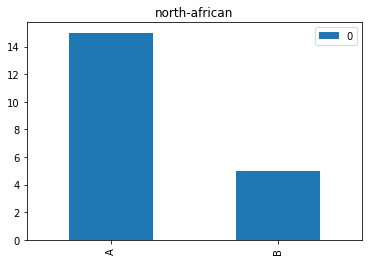

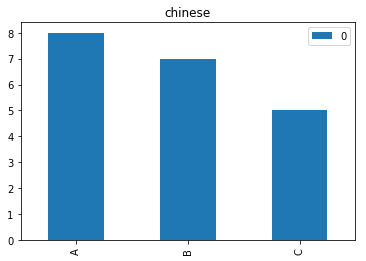

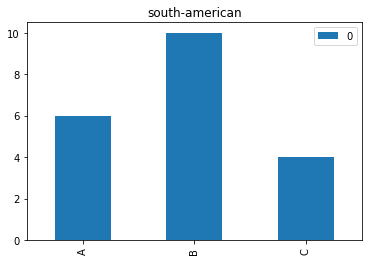

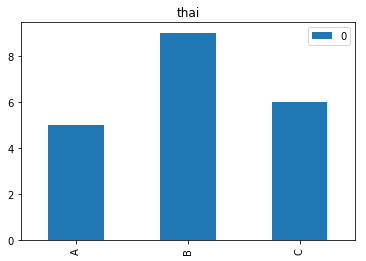

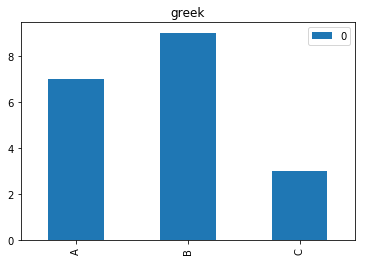

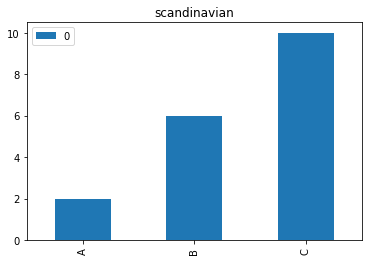

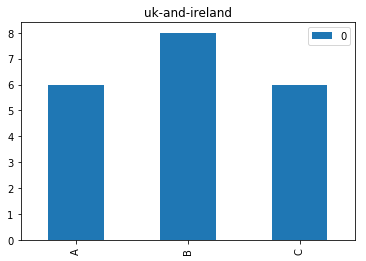

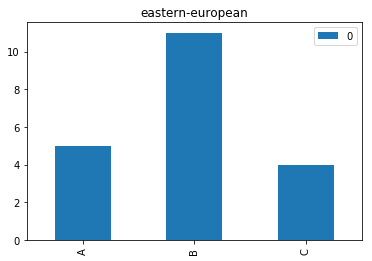

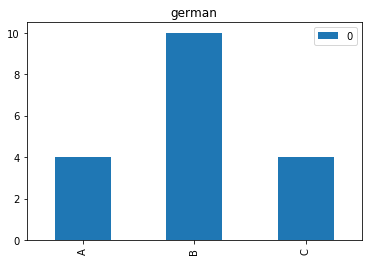

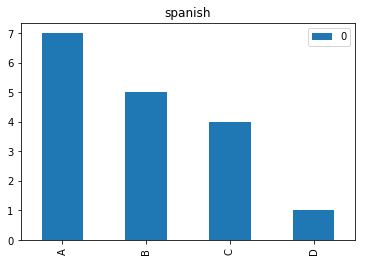

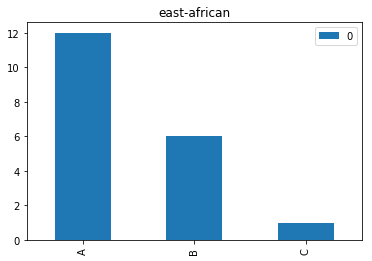

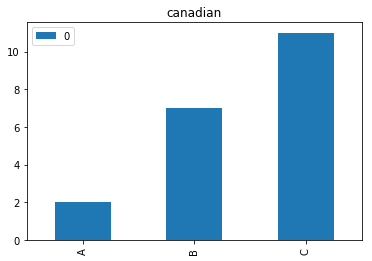

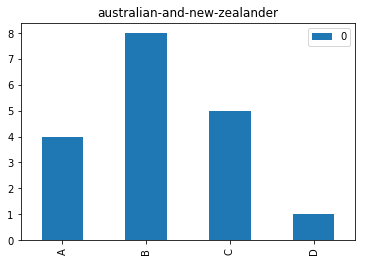

In [60]:
regions = Full['Region'].unique()
for region in regions:
    a=Full[Full['Region']==region].sort_values(by=['NutriScore'])['NutriLetter'].values
    letter_counts = Counter(a)
    df = pd.DataFrame.from_dict(letter_counts,orient = 'index')
    df.plot(kind='bar')
    plt.title(region)
    

In [61]:
Full.to_csv('data/fullWithNutri.csv')

## Tensorflow magic ##

In [ ]:
temp_path = 'tmp/'
ingDic = {}

for region in regions:
    jsonPath='data/'+region+'.json'
    with open(jsonPath, 'rb') as f:
        fullTheme=json.load(f)
    tmp = ''
    for recipe in fullTheme:
        #print(fullTheme[recipe])
        ingList=ingr2dic(fullTheme[recipe]['Ingredients'])
        for ing in ingList:
            tmp += ingList[ing]['name'].lstrip() + ', '
    ingDic[region] = tmp       

### See Google Colab notebook for code and results ###

The following figure is a similarity graph obtained by running the parsed (without quantities) ingredient lists of all themes through the Google Universal Sentence Encoder (Keras API for tensorflow) and computing the correlation matrix.

In [62]:
import networkx as nx
import seaborn as sns

In [63]:
from numpy import genfromtxt
corr = genfromtxt('data/corr.csv', delimiter=',',skip_header=1)
corr = corr[:,1:]
corr.shape

(18, 18)

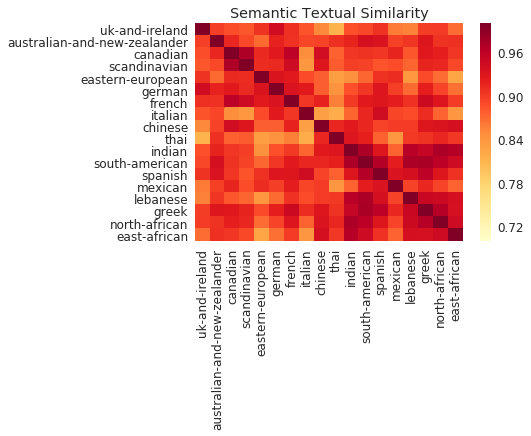

In [64]:
def plot_similarity(labels, features, rotation):
    corr = features
    sns.set(font_scale=1.2)
    g = sns.heatmap(
      corr,
      xticklabels=labels,
      yticklabels=labels,
      vmin=0.7,
      vmax=1,
      cmap="YlOrRd")
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")
    
regions = ['uk-and-ireland','australian-and-new-zealander','canadian','scandinavian','eastern-european','german','french','italian','chinese','thai','indian','south-american','spanish','mexican','lebanese','greek','north-african','east-african']

plot_similarity(regions,corr,90)

This is the graph formed with the highest connections.

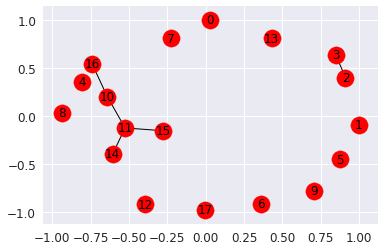

In [65]:
thresh = 0.97

result = (corr > thresh)*(corr-thresh)/(1-thresh)
A = nx.from_numpy_matrix(result)
nx.draw_networkx(A)

In [124]:
friends = pd.DataFrame(regions)
friends.columns=['Region']
corr = genfromtxt('data/corr.csv', delimiter=',',skip_header=1)
corr = corr[:,1:]
corr2 = corr - np.min(corr)

a = np.argmin(corr,axis=0)
c=friends.iloc[a].reset_index(drop=True, inplace=False)

np.fill_diagonal(corr,0)
a = np.argmax(corr,axis=0)
b=friends.iloc[a].reset_index(drop=True, inplace=False)

friends['Best Friend']=b 
friends['Worst Foe']=c
friends['Centralness'] = np.sum(corr2,axis=0)
friends.sort_values('Centralness',ascending= False)


,Region,Best Friend,Worst Foe,Centralness
15,greek,south-american,eastern-european,2.235492
11,south-american,greek,eastern-european,2.202670
12,spanish,south-american,thai,2.081118
16,north-african,indian,eastern-european,2.075636
6,french,canadian,thai,2.029232
10,indian,south-american,eastern-european,1.998498
2,canadian,scandinavian,italian,1.907336
1,australian-and-new-zealander,south-american,eastern-european,1.839630
14,lebanese,south-american,eastern-european,1.830797
5,german,uk-and-ireland,thai,1.791136


# Let's try some ML to find clusters and trends#

Several attempts were made to cluster countries based on their nutritional values. Different machine learning algorithms such as PCA, K-Nearest Neighbor, DBScan, decision trees were attempted to try and find means of clustering datapoints according to their respective class and thus being able to find similarities between regions. However, no significant result was found... This was to be expected since every country has very varied recipe types and cooking styles, but it is interesting to note that it is not achievable to find links between regions cooking styles in this way.

### Attempt at decision tree ###

In [70]:
from sklearn.preprocessing import StandardScaler

data = Full.drop(columns=['Popularity','Rating','Title','Reference','Vitamin A','NutriLetter'])
y= data.dropna()['Region']
X=StandardScaler().fit_transform(data.drop(columns=['Region']).dropna())

from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(y)
y = le.transform(y)


### Attempt at PCA ###

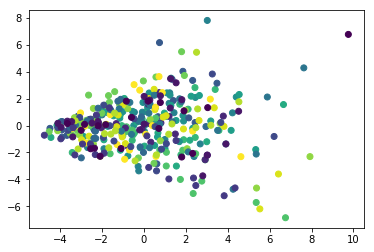

In [161]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)

principalComponents = pca.fit_transform(X)
c=y

principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

plt.scatter(principalDf['principal component 1'],principalDf['principal component 2'],c=(y))


### Attempt at DBScan ###

Automatically created module for IPython interactive environment
Estimated number of clusters: 5
Estimated number of noise points: 195
Homogeneity: 0.048
Completeness: 0.137
V-measure: 0.071
Adjusted Rand Index: 0.003
Adjusted Mutual Information: 0.007
Silhouette Coefficient: -0.049


/home/manuel/anaconda3/envs/ada2/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:732: FutureWarning: The behavior of AMI will change in version 0.22. To match the behavior of 'v_measure_score', AMI will use average_method='arithmetic' by default.
  FutureWarning)


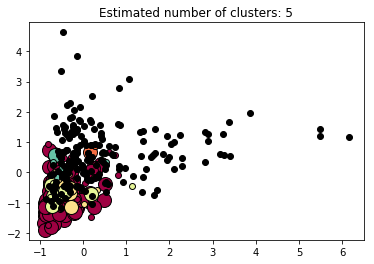

In [149]:
print(__doc__)

import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets.samples_generator import make_blobs
from sklearn.preprocessing import StandardScaler

# Compute DBSCAN
db = DBSCAN(eps=2, min_samples=5).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)

labels_true = y

print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(labels_true, labels))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, labels))

# #############################################################################
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

In [150]:
Full.iloc[labels == 0]['NutriScore'].describe()

count    137.000000
mean       0.386861
std        3.032297
min       -8.000000
25%       -1.000000
50%        1.000000
75%        2.000000
max        9.000000
Name: NutriScore, dtype: float64

In [151]:
Full.iloc[labels == 1]

,Calcium,Calories,Cholesterol,Dietary Fiber,Folate,Iron,Magnesium,Niacin,Popularity,Potassium,...,Thiamin,Title,Total Carbohydrates,Total Fat,Vitamin A,Vitamin B6,Vitamin C,VeggieWeight,NutriScore,NutriLetter
Italian Spaghetti Sauce with Meatballs,140.0,349,77.0,4.5,46.0,6.0,59.0,9.0,4000.0,1023.0,...,0.0,Italian Spaghetti Sauce with Meatballs,23.7,21.2,825IU,1.0,33.0,363.0,-1,A
Mellas Family Lamb Stuffed Zucchini (Koosa),129.0,511,76.0,5.0,86.0,5.0,79.0,12.0,14.0,1185.0,...,0.0,Mellas Family Lamb Stuffed Zucchini (Koosa),44.8,26.6,762IU,1.0,49.0,326.0,-2,A
Spanakopita (Greek Spinach Pie),495.0,494,100.0,7.4,391.0,8.0,175.0,7.0,905.0,1304.0,...,0.0,Spanakopita (Greek Spinach Pie),31.5,34.7,12264IU,1.0,62.0,236.0,0,B
Diane's Colcannon,59.0,250,26.0,4.6,46.0,1.0,43.0,3.0,843.0,756.0,...,0.0,Diane's Colcannon,29.8,12.6,258IU,1.0,45.0,190.0,-1,A
The Best Steak Marinade,28.0,156,0.0,0.2,4.0,1.0,9.0,1.0,1000.0,188.0,...,0.0,The Best Steak Marinade,7.8,13.5,14IU,0.0,3.0,1.0,3,C


# Health data 

We want to study the impact of the most popular recipes on the health of people. To be able to achieve that goal we need some data about food related diseases. We chose to focus on overweight / obesity and diabetes in each region of the world. We got the data from the World Health Organization (WHO).
​
The datasets we chose to use are the following:
- percentage of overweight (BMI > 25) people in each country / world region
- percentage of obesity (BMI > 30) in each country / world region
- percentage of diabetes in each country / wolrd region

### Necessary imports, data paths and loading of datasets into dataframes

In [3]:
#Dataset paths
health_data_path = 'data/health/originals/'
project_health_data_path = 'data/health/project_adapted/'

#LOAD THE DATASETS

#Percentage of dying between the ages of 30-70 of cardiovascular and respiratory diseases, cancer, diabetes by country and region
mortality_country = pd.read_csv(project_health_data_path + 'NCDMORT3070.csv', skiprows = 1)
mortality_region = pd.read_csv(project_health_data_path + 'diseases_region.csv', skiprows = 1)

#Percentage of diabetes by country
diabetes_country = pd.read_csv(project_health_data_path + 'diabetes.csv', index_col = 0)
diseases_region = pd.read_csv(project_health_data_path + 'diseases.csv')

#Percentage of overweight by country and region
overweight_country = pd.read_csv(project_health_data_path + 'overweight_country.csv', index_col = 0)
overweight_region = pd.read_csv(project_health_data_path + 'overweight_region.csv', index_col = 0)

#Percentage of obesity by country and region
obesity_country = pd.read_csv(project_health_data_path + 'obesity_country.csv', index_col = 0)
obesity_region = pd.read_csv(project_health_data_path + 'obesity_region.csv', index_col = 0)

### Clean the data

In [4]:
#Set column names
newcols = ['Country', 'Year', 'Both sexes', 'Male', 'Female']
newcols1 = ['Country', 'Diabete percentage']
newcols2 = ['Region', 'Obesity percentage']
newcols3 = ['Region', 'Overweight percentage']
mortality_country.columns = newcols
mortality_region.columns = newcols
diabetes_country.columns = newcols1
obesity_region.columns = newcols2
overweight_region.columns = newcols3

In [5]:
overweight_country.shape

(195, 2)

In [6]:
overweight_country.isnull().values.any()

False

In [7]:
obesity_country.shape

(195, 2)

In [8]:
obesity_country.isnull().values.any()

False

In [9]:
diabetes_country.shape

(253, 2)

In [10]:
diabetes_country.isnull().values.any()

False

We find the same number of countries in the overweight and obesity datasets, we will merge this two along with the diabetes dataset, at first we choose to merge the first two dataframes and compare the countries with the diabetes dataset to check for any country names that might need to be changed.

In [11]:
#Merge overweight, obesity and diabetes data for each country on a single dataframe
result = pd.merge(overweight_country, obesity_country, on= 'Country')
result2 = pd.merge(result, diabetes_country, on='Country')
result2.head()

,Country,Overweight percentage,Obesity percentage,Diabete percentage
0,Afghanistan,19.7,4.5,9.59
1,Albania,58.7,22.3,10.08
2,Algeria,60.7,26.6,6.73
3,Andorra,68.1,28.0,7.97
4,Angola,23.9,6.8,3.94


# Why our interest to find any correlations between health markers and nutrition?

Noncommunicable diseases (NCDs) are the leading causes of death and were responsible for an estimated 39.5 million (72%) of the world’s 54.7 million deaths in 2016. Of the major NCDs, cardiovascular diseases (CVD) were the leading cause of NCD mortality in 2016 and was responsible for nearly half of all NCD deaths. Modifiable risk factors such as unhealthy diet, physical inactivity, tobacco use and harmful use of alcohol are major causes of CVDs. Dietary saturated fatty acids and trans-fatty acids are of particular concern as high levels of intake are correlated with increased risk of CVDs.

Saturated fatty acid and trans-fatty foods photoWHO/Pixabay
Saturated fatty acids are found in foods from animal sources such as butter, milk, meat, salmon, and egg yolks, and some plant-derived products such as chocolate and cocoa butter, coconut, palm and palm kernel oils. Trans-fatty acids can be industrially produced by the partial hydrogenation of vegetable and fish oils, but also occur naturally in meat and dairy products from ruminant animals (e.g. cattle, sheep, goats, camels, etc.). Industrially-produced trans-fatty acids can be found in baked and fried foods (e.g. doughnuts, cookies, crackers and pies), pre-packaged snacks and food, and partially hydrogenated cooking oils and fats which are often used at home, in restaurants, or in the informal sector, such as street vendors.

On the other hand, childhood obesity is one of the most serious global public health challenges of the 21st century, affecting every country in the world. In just 40 years the number of school-age children and adolescents with obesity has risen more than 10-fold, from 11 million to 124 million (2016 estimates). In addition, an estimated 216 million were classified as overweight but not obese in 2016.

The condition also affects younger children, with over 38 million children aged under 5 living with overweight or obesity in 2017. The epidemic has been growing most rapidly in low- and middle-income countries, particularly in Northern and Southern Africa, the Middle East and the Pacific Islands. Although most countries are still off-track to meet the 2025 targets, many are taking action and some have achieved a levelling-off in childhood obesity rates. Investing in children’s health will help meet the global health targets and substantially reduce the predicted health and economic costs of obesity.

### Let's start by analizing our data

In health studies is always interesting to define gender-specific biases especially in cardio-respiratories diseases where it has been shown that it affects 30% more the male population form ages 18-45.

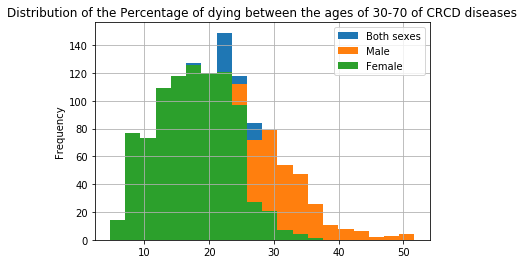

In [12]:
#Distribution of the percentage of dying of CRCD diseases by country
#Note: CRCD - Cardio-respiratory, cancer and diabetes

mortality_copy = mortality_country.copy()
mortality_copy.drop(['Year'], axis = 1, inplace = True)
mortality_copy.groupby(['Country']).mean()

#Plotting all
hx = mortality_copy.plot(kind = 'hist', bins = 20, grid = True, title = 'Distribution of the Percentage of dying between the ages of 30-70 of CRCD diseases' );


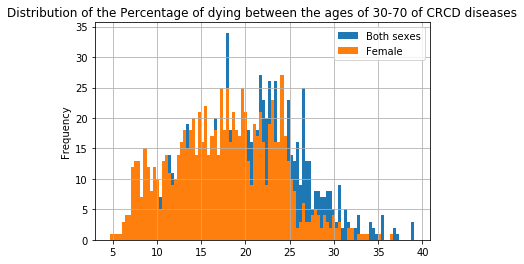

In [13]:
test = mortality_country.copy()
test.drop(['Year', 'Male'], axis = 1, inplace = True)
test.groupby(['Country']).apply(lambda x : x-15)

test.plot(kind = 'hist', bins = 100, grid = True, title = 'Distribution of the Percentage of dying between the ages of 30-70 of CRCD diseases' );


We thus, confirm that as the male population gets the older, the risk of somatizing one of the following diseases: 

Cardiovascular 

Respiratory

Cancer

Diabetes

Increases with respect to the female population from the ages 18-45. The frequency of deaths appears also higher in the eldest years of life and stops around 60 years old. We also visualize the fact that in most countries the percentage of dying form one of these diseases is the highest at around 25% which means that 25% of the population in most countries is dying from these disease. Thus, it is not really necessary to separate the male/female population as we only want an overwiew of the food choice related to the different countries.

The figure above shows the percentage of dying of CRCD diseases between the ages 30-70 for male and female populations. We observe that these diseases affect, by visual inspection, more the male population. The mean for both sexes is placed at around 22 percent.

### Now let's add our calculations for the nutriscore for our scraped international recipes and see if we find any interesting correlations

In [14]:
nutriscore = pd.read_csv('fullWithNutri.csv', index_col=0)
nutriscore.head()

,Calcium,Calories,Cholesterol,Dietary Fiber,Folate,Iron,Magnesium,Niacin,Popularity,Potassium,...,Thiamin,Title,Total Carbohydrates,Total Fat,Vitamin A,Vitamin B6,Vitamin C,VeggieWeight,NutriScore,NutriLetter
Low-Carb Jicama Tostadas,18.0,57,0.0,7.4,18.0,1.0,18.0,0.0,3.0,225.0,...,0.0,Low-Carb Jicama Tostadas,13.2,0.1,32IU,0.0,30.0,0.0,-2,A
Best Fish Tacos,80.0,322,35.0,3.8,88.0,3.0,48.0,6.0,3.0,591.0,...,0.0,Best Fish Tacos,34.6,9.0,1043IU,0.0,18.0,145.0,-1,A
Crispy Pork Carnitas,35.0,317,89.0,0.4,5.0,2.0,23.0,10.0,267.0,371.0,...,1.0,Crispy Pork Carnitas,2.1,22.6,17IU,0.0,2.0,16.0,2,B
Jeannie's Vegetarian Enchiladas,376.0,626,59.0,9.6,193.0,6.0,77.0,8.0,1.0,818.0,...,1.0,Jeannie's Vegetarian Enchiladas,67.2,31.2,2569IU,0.0,49.0,172.0,2,B
Mexican Corn Bread Casserole,168.0,304,101.0,1.9,58.0,2.0,28.0,6.0,21.0,372.0,...,0.0,Mexican Corn Bread Casserole,21.5,16.3,840IU,0.0,12.0,58.0,2,B


The Nutriscore is a standard way of measuring the nutritious value of any given plate/recipe/food and standardizes these values regardless of a possible existance of high levels of sugars, fats, ot proteins as a given recipe can contain high amounts of fruits and vegetables and still contain a high sugar consumption for example.

Nowadays, public health institutions, diet fads and regimes, and the whole fitness industries have recognized the importance of a low-sugar healthy-based diet. In the following results and calculation we will map certain macronutrients deem as crucial to the development of health-related markers with respect to cardio-respiratory, cancer and diabetes in both countries and regions of the world.

Let's start by calculation the ratio of sugar to calories. To do so, a sugar is considered to have 4 kcal/g thus for each gram of sugar we have 4 kcal of energy. We will also explore the prevalence of saturated fats and protein content, fats are assumed to have 9kcal/g and protein 4kcal/g.

In [15]:
#Sugar consumption

##For sugar consumption we calculate the ratio of sugar to the number of calories
nutriscore['Sugar Consumption'] = nutriscore['Sugars']*4/nutriscore['Calories']*100

##We take the food for which their sugar content is >= 25% 
sugar_region = nutriscore[nutriscore['Sugar Consumption'] >= 25][['Region', 'Sugar Consumption']].groupby('Region').mean()
sugar_region.reset_index(level=0, inplace=True)

## Ratio Saturated fats/calories
total_cals = nutriscore.groupby('Region')['Calories'].mean()
fats = nutriscore.groupby('Region')['Saturated Fat'].mean().apply(lambda x: x*9)/total_cals*100

##Ratio protein/calories
proteins = nutriscore.groupby('Region')['Protein'].mean().apply(lambda x: x*4)/total_cals*100

##NutriScore
nutri = nutriscore.groupby('Region')['NutriScore'].mean()

### Is a high consumption of sugar a real indicator of obesity, overweight or diabetes prevalence in the regions of the world?

In [16]:
old_regions = ['australian-and-new-zealander', 'canadian', 'chinese', 'east-african', 'eastern-european',
            'german', 'scandinavian', 'south-american', 'spanish', 'thai']
new_regions = ['Western Pacific', 'Americas', 'South-East Asia', 'Africa', 
            'Eastern-Mediterranean', 'Europe', 'Europe', 'Americas', 'Europe', 
            'South-East Asia' ]
sugar_region['Region'].replace(old_regions, new_regions, inplace = True)
sugar_region = sugar_region.groupby(['Region']).mean()
sugar_region.reset_index(level=0, inplace=True)
obesity_region = obesity_region.drop(obesity_region.index[len(obesity_region)-1])
overweight_region = overweight_region.drop(overweight_region.index[len(overweight_region)-1])

In [17]:
result0 = pd.merge(obesity_region, sugar_region, on = 'Region')
result1 = pd.merge(result0, overweight_region, on = 'Region')

Text(0.5,0,'5 Regions of the World')

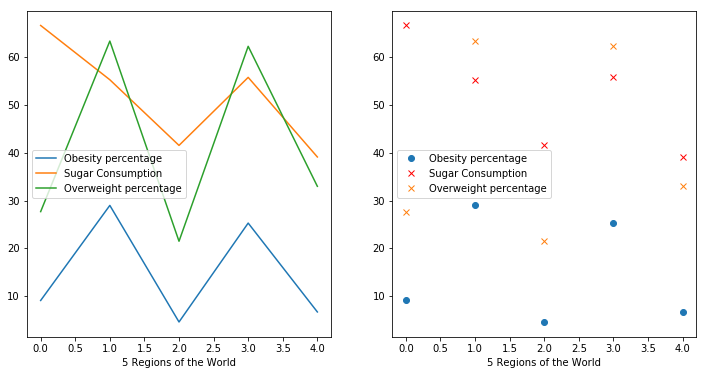

In [18]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(12,6))
ax1 = result1.plot(ax=axes[0])
ax1.set_xlabel("5 Regions of the World")
ax2 = result1.plot(ax=axes[1], style=['o','rx', 'x'])
ax2.set_xlabel("5 Regions of the World")

Let's finish this section by calculation the **Pearson coefficient** out of these values and confirm our results.

In [19]:
result1.corr()

,Obesity percentage,Sugar Consumption,Overweight percentage
Obesity percentage,1.000000,0.416353,0.979070
Sugar Consumption,0.416353,1.000000,0.296885
Overweight percentage,0.979070,0.296885,1.000000


What's up with these results? Clearly there is no surprise and there's an almost perfect positive Pearson correlation between obesity and overweight per region of the world. **However, there's no clear evidence that a higher consumption of sugar found on the most popular dishes of the different regions of the world plays a role on the obesity or overweight percentage in the same region.**

The latter is due to the fact that we don't have a lot of different recipes, also the sugar content was placed at 25% of sugar contained in the recipe and while this is an important assumption there is clearly no need to look for further information regarding this aspect, we will continue our study in the quest of predicting health-related conditions from our recipe data.

### Is a high consumption of saturated fats and protein content a real indicator of obesity, overweight or diabetes prevalence in the countries of the world?

In [20]:
fat_prot = pd.concat([fats, proteins, nutri], axis=1).reset_index()
fat_prot.drop([3,4,13], inplace=True)
fat_prot.columns = ['Region', 'Saturated fat', 'Protein content', 'NutriScore']

In [21]:
result_region = pd.merge(diseases_region, fat_prot, on = 'Region')
result_region.head()

,Region,Overweight percentage,Obesity percentage,Diabetes percentage,Mortality,Saturated fat,Protein content,NutriScore
0,australian-and-new-zealander,67.2,30.4,5.07,9.1,15.593452,16.076398,2.052632
1,canadian,67.5,31.3,7.37,9.8,16.313505,18.238448,2.050000
2,chinese,33.8,6.6,9.74,17.0,8.923850,26.060286,0.600000
3,french,62.9,23.2,4.77,10.6,29.679144,17.956031,2.421053
4,german,62.8,25.7,5.06,12.1,14.169550,17.979239,1.222222


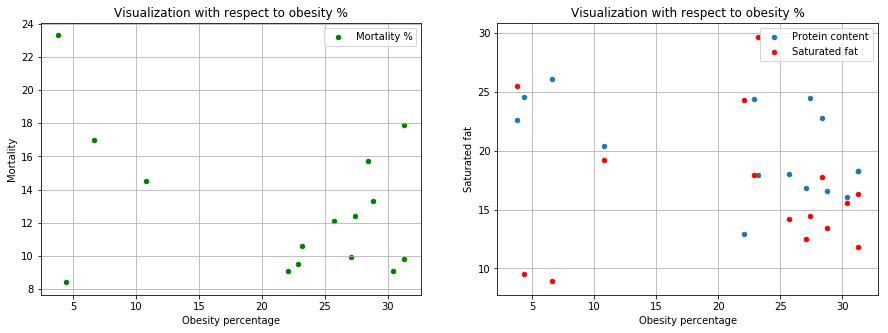

In [22]:
#Visualization with respect to obesity
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,5))

ax1 = result_region.plot(kind = 'scatter', ax=axes[0], x = 'Obesity percentage', y = 'Mortality', label = 'Mortality %', color = 'g', grid = True, title = "Visualization with respect to obesity %")
ax2 = result_region.plot(kind = 'scatter', x = 'Obesity percentage', y = 'Protein content', label = 'Protein content', ax = axes[1], grid = True)
ax3 = result_region.plot(kind = 'scatter', x = 'Obesity percentage', y = 'Saturated fat', label = 'Saturated fat', ax = axes[1], color = 'r', grid = True, title = "Visualization with respect to obesity %")

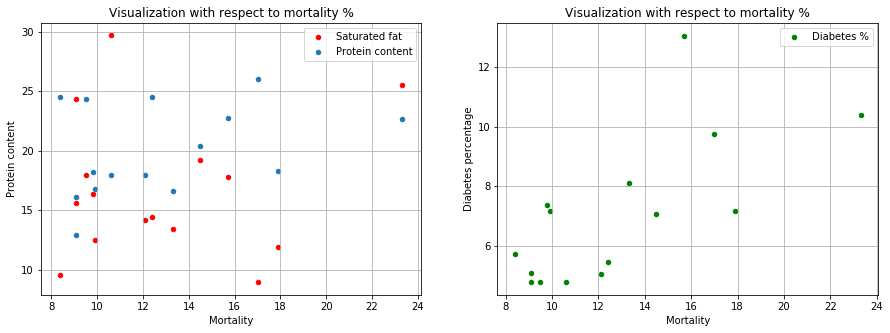

In [23]:
#Visualization with respect to mortality
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,5))

ax1 = result_region.plot(kind = 'scatter', ax=axes[0], x = 'Mortality', y = 'Saturated fat', label = 'Saturated fat', color = 'r', grid = True, title = "Visualization with respect to mortality %")
ax2 = result_region.plot(kind = 'scatter', x = 'Mortality', y = 'Protein content', label = 'Protein content', ax = axes[0], grid = True)
ax3 = result_region.plot(kind = 'scatter', x = 'Mortality', y = 'Diabetes percentage', label = 'Diabetes %', ax = axes[1], color = 'g', grid = True, title = "Visualization with respect to mortality %")

We proposed to two different visualizations, the first one with respect the obesity percentage. We see no clear correlation between a higher consumption of saturated fats or protein. However, for a high percentage of obesity in the regions there is a small cluster of regions that have high tendancy of mortality. On the second figure we observe the consumption of satrated fats and protein a long a mortality axis. Again it is not possible to draw any conclusions from this visualization.

Let's calculate the correlation matrix between our variables:

In [24]:
result_region.corr()

,Overweight percentage,Obesity percentage,Diabetes percentage,Mortality,Saturated fat,Protein content,NutriScore
Overweight percentage,1.000000,0.971822,-0.313933,-0.496330,-0.044760,-0.497910,0.050246
Obesity percentage,0.971822,1.000000,-0.193628,-0.361304,-0.049713,-0.539843,-0.019222
Diabetes percentage,-0.313933,-0.193628,1.000000,0.696534,-0.093171,0.345717,-0.474333
Mortality,-0.496330,-0.361304,0.696534,1.000000,0.092514,0.333359,-0.542228
Saturated fat,-0.044760,-0.049713,-0.093171,0.092514,1.000000,-0.294427,0.527613
Protein content,-0.497910,-0.539843,0.345717,0.333359,-0.294427,1.000000,-0.492726
NutriScore,0.050246,-0.019222,-0.474333,-0.542228,0.527613,-0.492726,1.000000


### **What about the nutriscore?** Let's see how the nutriscore is represented in the diferent regions of the world...

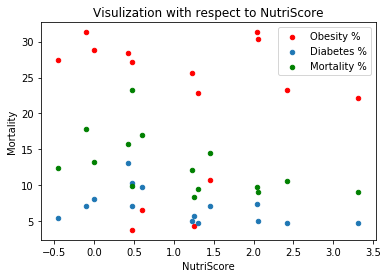

In [25]:
#Visualization with respect to NutriScore
ax1 = result_region.plot(kind = 'scatter', x = 'NutriScore', y = 'Obesity percentage', label = 'Obesity %', color = 'r', title = "Visulization with respect to NutriScore")
ax2 = result_region.plot(kind = 'scatter', x = 'NutriScore', y = 'Diabetes percentage', label = 'Diabetes %', ax = ax1)
ax3 = result_region.plot(kind = 'scatter', x = 'NutriScore', y = 'Mortality', label = 'Mortality %', ax = ax1, color = 'g')

### Finally, how about we try find any  correlation between the quantity of both the saturated fats and sugar content...

In [59]:
sugars = nutriscore.groupby('Region')['Sugars'].mean().apply(lambda x: x*4)/total_cals*100
fats_sugars = pd.DataFrame(sugars+fats, columns=['% Saturated fats and sugar'])
result_fat_sugar = pd.merge(diseases_region, fats_sugars, on = 'Region')
result_fat_sugar.head()

,Region,Overweight percentage,Obesity percentage,Diabetes percentage,Mortality,% Saturated fats and sugar
0,australian-and-new-zealander,67.2,30.4,5.07,9.1,26.398363
1,canadian,67.5,31.3,7.37,9.8,27.546592
2,chinese,33.8,6.6,9.74,17.0,26.745108
3,french,62.9,23.2,4.77,10.6,36.393345
4,german,62.8,25.7,5.06,12.1,25.173010


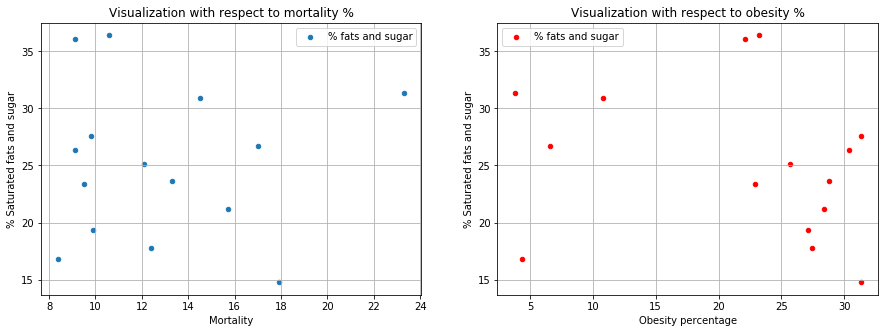

In [64]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(15,5))

ax1 = result_fat_sugar.plot(kind = 'scatter', ax=axes[0], x = 'Mortality', y = '% Saturated fats and sugar', label = '% fats and sugar', grid = True, title = "Visualization with respect to mortality %")
ax2 = result_fat_sugar.plot(kind = 'scatter', ax=axes[1], x = 'Obesity percentage', y = '% Saturated fats and sugar', label = '% fats and sugar', color = 'r', grid = True , title = "Visualization with respect to obesity %")

In [65]:
result_fat_sugar.corr()

,Overweight percentage,Obesity percentage,Diabetes percentage,Mortality,% Saturated fats and sugar
Overweight percentage,1.000000,0.971822,-0.313933,-0.496330,-0.205713
Obesity percentage,0.971822,1.000000,-0.193628,-0.361304,-0.226529
Diabetes percentage,-0.313933,-0.193628,1.000000,0.696534,-0.122808
Mortality,-0.496330,-0.361304,0.696534,1.000000,0.002770
% Saturated fats and sugar,-0.205713,-0.226529,-0.122808,0.002770,1.000000


### Why do we obtain these results? 

It is clear that a healthy diet and exercise are essential for a long, fulfilling live. But it is not always the quality of the food and its macronutrients who will determine health-related condition all over the world. The socio-economic impact on the health of the people is extremely significant. As you will see in the next study case. Several regions of the world have a low obesity and low consumption of sugars and saturated fats however their mortality is on the other side of the spectrum. Regions of the world, namely Africa, Asia and South America suffer from extreme poverty and food is not available to them. It thus, very difficult to get any interesting correlation from these databases. However, we were able to prove how the male population sufferes from cardio-respiratory diseases in a higher frequency than women. It will be interesting to showcase our case study and compare the health markers, sugar and fat consumption of a well established country: Canada

# Case Study: Canada

In [68]:
canadian_recipes = nutriscore[nutriscore['Region'] == 'canadian'].reset_index()
canadian_recipes.head()

,index,Calcium,Calories,Cholesterol,Dietary Fiber,Folate,Iron,Magnesium,Niacin,Popularity,...,Title,Total Carbohydrates,Total Fat,Vitamin A,Vitamin B6,Vitamin C,VeggieWeight,NutriScore,NutriLetter,Sugar Consumption
0,The Best Rolled Sugar Cookies,14.0,109,25.0,0.3,21.0,1.0,3.0,1.0,15000.0,...,The Best Rolled Sugar Cookies,14.7,5.0,158IU,0.0,0.0,0.0,1,B,25.688073
1,Butternut Squash Soup II,178.0,305,21.0,9.5,111.0,3.0,136.0,6.0,3000.0,...,Butternut Squash Soup II,59.7,6.8,35991IU,1.0,89.0,232.0,0,B,13.114754
2,Old Fashioned Onion Rings,265.0,641,69.0,3.5,146.0,4.0,40.0,8.0,1000.0,...,Old Fashioned Onion Rings,68.3,34.6,256IU,0.0,4.0,37.0,5,C,4.992200
3,Crispy Orange Beef,122.0,507,60.0,5.9,197.0,5.0,79.0,11.0,1000.0,...,Crispy Orange Beef,59.2,18.7,1280IU,1.0,189.0,10.0,0,B,13.412229
4,Boneless Buffalo Wings,131.0,710,136.0,1.7,89.0,4.0,41.0,15.0,1000.0,...,Boneless Buffalo Wings,43.7,46.9,751IU,0.0,15.0,0.0,6,C,2.253521


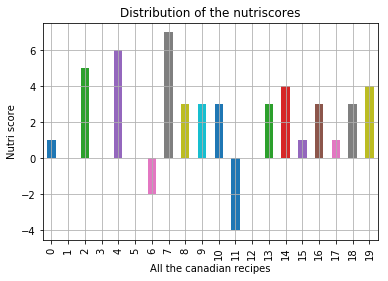

In [69]:
ax = canadian_recipes['NutriScore'].plot(kind = 'bar', grid = True, title = 'Distribution of the nutriscores')
ax.set_xlabel("All the canadian recipes");
ax.set_ylabel("Nutri score");

First of all, as a remainder, the recipe is considered healthy when the nutriscore is negative and unhealthy when its positive. We observe a higher number of unhealthy recipes in the canadian traditional cuisine.

### Let's visualize how the nutriscores of the canadian recipes compare to the rest

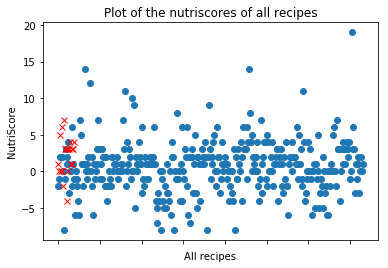

In [70]:
hx1 = nutriscore['NutriScore'].plot(style=['o'], title = "Plot of the nutriscores of all recipes")
hx2 = canadian_recipes['NutriScore'].plot(style=['rx'], label = 'Canadian recipes', ax = hx1)
hx2.set_xlabel("All recipes");
hx2.set_ylabel("NutriScore");

As seen above, the nutriscore of the canadian recipes is set around the mean value of the other recipes, all clustered around the [-5, 5] region

In [71]:
diseases_region[diseases_region['Region'] == 'canadian']

,Region,Overweight percentage,Obesity percentage,Diabetes percentage,Mortality
1,canadian,67.5,31.3,7.37,9.8


To continue our analysis, we will explore how the different health-related markers are presented over the world, here we use the median as a method to avoid extreme values present in regions such as african or asian countries.

In [72]:
params_health = ['Overweight percentage', 'Obesity percentage', 'Diabetes percentage', 'Mortality', 'Sugar Consumption', 
                'Saturated fat', 'NutriScore']

#Calculate WORLD median values
overweight_m = diseases_region['Overweight percentage'].median()
obesity_m = diseases_region['Obesity percentage'].median()
diabetes_m = diseases_region['Diabetes percentage'].median()
mortality_m = diseases_region['Mortality'].median()
sugar_m = nutriscore['Sugar Consumption'].median()
fat_m = nutriscore['Saturated Fat'].median()
nutriscore_m = nutriscore['NutriScore'].median()
world_values = [overweight_m, obesity_m, diabetes_m, mortality_m, sugar_m, fat_m, nutriscore_m]

#Calculate CANADIAN values
canada_values = diseases_region[diseases_region['Region'] == 'canadian']
overweight_c = canada_values['Overweight percentage'].mean()
obesity_c = canada_values['Obesity percentage'].mean()
diabetes_c = canada_values['Diabetes percentage'].mean()
mortality_c = canada_values['Mortality'].mean()
sugar_c = canadian_recipes['Sugar Consumption'].mean()
fat_c = canadian_recipes['Saturated Fat'].mean()
nutriscore_c = canadian_recipes['NutriScore'].mean()
canada_values = [overweight_c, obesity_c, diabetes_c, mortality_c, sugar_c, fat_c, nutriscore_c]

In [86]:
canada_world = pd.DataFrame(np.row_stack([world_values, canada_values]), 
                               columns=params_health)
canada_world.rename({0: 'World', 1: 'Canada'}, axis='index')

,Overweight percentage,Obesity percentage,Diabetes percentage,Mortality,Sugar Consumption,Saturated fat,NutriScore
World,64.1,26.4,6.395,11.5,5.228758,5.0,1.00
Canada,67.5,31.3,7.370,9.8,13.035867,7.1,2.05


It is not possible to predict health-related markers with a high level of accuracy with our data. However, we observe that Canada has a high consumption of saturated fat and sugar (well above the median), it's nutriscore (remember: the lowest it is, the better and healthier the food is) shows also an unhealthy trend and above all, the health-related markers: Overweight, Obesity and Diabetes are also above the median. This simple but insighful case study shows that if we wanted to predict at a high level of accuracy the health conditions of a country from its traditional food/recipes we would need also a socio-economic study (mentioned before) in order to eliminate such factors and focus exclusively on the correlation between the quality of available food and different health conditions. As an example, China has a small consumption of sugar and saturated fats but the fact that the socio-economic atmosphere is not the best to grow healthy affected our studies. Also, some other african and asian countries presented high levels of sugar consumption but low obesity due to the fact that poverty is very common in these regions.

## Is the nutriscore a real indicator of health-related markers in countries?

In a nutshell, it is not. The socio-economic gap and rich/poor balance are too big to be ignored. They have to be taken into account or choose only industrialized countries from the globe. The data available from the recipes is also not enough to draw any interesting correlations between the health markers, but some interesting conclusions can be obtained from it. The case study: Canada showed interesting information on how higher consumption of fats and sugars, and a low quality of food (measured by the nutriscore) has a mild impact on the health of their citizens in comparison to the world's health-markers. Again, this information should be taken with proper care. One other important factor to mention is the fact that the recipes provided by the websites target (mainly) US citizens, whose diet differs from the countries' authentic. 